<a href="https://colab.research.google.com/github/RCCyber/RCCyber/blob/main/detect_employees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential, Model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Activation, Flatten, Dropout

from keras import backend as K
K.image_dim_ordering='th'

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt

In [ ]:
!cd /content/sample_data/ && unzip data.zip

In [3]:
inc_model=InceptionV3(include_top=False, 
                      weights='imagenet', 
                      input_shape=((116, 116, 3)))

87924736/87910968 [==============================] - 1s 0us/step


In [4]:
bottleneck_datagen = ImageDataGenerator(rescale=1./255)  #собственно, генератор
    
train_generator = bottleneck_datagen.flow_from_directory('/content/sample_data/data/train/',
                                        target_size=(116, 116),
                                        batch_size=32,
                                        class_mode=None,
                                        shuffle=False)

validation_generator = bottleneck_datagen.flow_from_directory('/content/sample_data/data/validation/', 
                                                              target_size=(116, 116),
                                                               batch_size=32,
                                                               class_mode=None,
                                                               shuffle=False)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
bottleneck_features_train = inc_model.predict(train_generator, 2000)
np.save(open('bn_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_validation = inc_model.predict(validation_generator, 2000)
np.save(open('bn_features_validation.npy', 'wb'), bottleneck_features_validation)

In [6]:
train_data = np.load(open('bn_features_train.npy', 'rb'))
train_labels = np.array([0] * 1000 + [1] * 1000) 

validation_data = np.load(open('bn_features_validation.npy', 'rb'))
validation_labels = np.array([0] * 1000 + [1] * 1000)

In [7]:
fc_model = Sequential()
fc_model.add(Flatten(input_shape=train_data.shape[1:]))
fc_model.add(Dense(64, activation='relu', name='dense_one'))
fc_model.add(Dropout(0.5, name='dropout_one'))
fc_model.add(Dense(64, activation='relu', name='dense_two'))
fc_model.add(Dropout(0.5, name='dropout_two'))
fc_model.add(Dense(1, activation='sigmoid', name='output'))

fc_model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [8]:
#validation_labels = validation_labels.reshape(1, -1)
#train_labels = train_labels.reshape(1, -1)
print(validation_data.shape)
print(validation_labels.shape)
print(train_data.shape)
print(train_labels.shape)

(2000, 2, 2, 2048)
(2000,)
(2000, 2, 2, 2048)
(2000,)


In [9]:
callback1 = EarlyStopping(monitor='val_loss', patience=5)
callbacks1=[callback1]

In [10]:
fc_model.fit(train_data, train_labels, epochs=50, batch_size=32, validation_data=(validation_data, validation_labels), callbacks=callbacks1)
fc_model.save_weights('fc_inception_presence_absence_250.hdf5') # сохраняем веса

Epoch 1/50
63/63 [==============================] - 3s 10ms/step - loss: 0.3503 - accuracy: 0.9145 - val_loss: 0.1302 - val_accuracy: 0.9665
Epoch 2/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0930 - accuracy: 0.9720 - val_loss: 0.2149 - val_accuracy: 0.9635
Epoch 3/50
63/63 [==============================] - 0s 6ms/step - loss: 0.0688 - accuracy: 0.9785 - val_loss: 0.1499 - val_accuracy: 0.9745
Epoch 4/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.9860 - val_loss: 0.2639 - val_accuracy: 0.9730
Epoch 5/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9910 - val_loss: 0.2590 - val_accuracy: 0.9660
Epoch 6/50
63/63 [==============================] - 1s 9ms/step - loss: 0.0425 - accuracy: 0.9905 - val_loss: 0.5360 - val_accuracy: 0.9355


In [11]:
fc_model.evaluate(validation_data, validation_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.5360 - accuracy: 0.9355


[0.5359904766082764, 0.9355000257492065]

In [12]:
weights_filename='fc_inception_presence_absence_250.hdf5'
x = Flatten()(inc_model.output)
x = Dense(64, activation='relu', name='dense_one')(x)
x = Dropout(0.5, name='dropout_one')(x)
x = Dense(64, activation='relu', name='dense_two')(x)
x = Dropout(0.5, name='dropout_two')(x)
top_model=Dense(1, activation='sigmoid', name='output')(x)
model = Model(inputs=inc_model.input, outputs=top_model)

In [13]:
weights_filename='fc_inception_presence_absence_250.hdf5'
model.load_weights(weights_filename, by_name=True)

In [14]:
for layer in inc_model.layers[:205]:
    layer.trainable = False

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
                #optimizer='rmsprop',
              metrics=['accuracy'])

In [16]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,  monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss',patience=7, verbose=1, mode='auto')
callbacks_list = [checkpoint, early_stop]

In [17]:
train_datagen = ImageDataGenerator(
        rescale=1./255)#,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/sample_data/data/train/',
        target_size=(116, 116),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/sample_data/data/validation/',
        target_size=(116, 116),
        batch_size=32,
        class_mode='binary')


pred_generator=test_datagen.flow_from_directory('/content/sample_data/data/validation/',
                                                     target_size=(116,116),
                                                     batch_size=100,
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
steps_per_epoch = 2000 // 32

validation_steps = 2000 // 32

In [19]:
model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        #nb_val_samples=2000,
        callbacks=callbacks_list)

Epoch 1/200
62/62 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9502
Epoch 1: val_accuracy improved from -inf to 0.90524, saving model to weights-improvement-01-0.91.hdf5
62/62 [==============================] - 13s 116ms/step - loss: 0.1903 - accuracy: 0.9502 - val_loss: 0.4972 - val_accuracy: 0.9052
Epoch 2/200
61/62 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9799
Epoch 2: val_accuracy improved from 0.90524 to 0.93952, saving model to weights-improvement-02-0.94.hdf5
62/62 [==============================] - 5s 88ms/step - loss: 0.0701 - accuracy: 0.9802 - val_loss: 0.2282 - val_accuracy: 0.9395
Epoch 3/200
62/62 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9929
Epoch 3: val_accuracy improved from 0.93952 to 0.95766, saving model to weights-improvement-03-0.96.hdf5
62/62 [==============================] - 6s 91ms/step - loss: 0.0314 - accuracy: 0.9929 - val_loss: 0.1529 - val_accuracy: 0.9577
Epoch 4/200

In [24]:
model.evaluate(pred_generator, batch_size=100)

20/20 [==============================] - 2s 89ms/step - loss: 0.1290 - accuracy: 0.9650


[0.12897147238254547, 0.9649999737739563]

In [31]:
imgs,labels=pred_generator.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
rounded_pred=np.asarray([i for i in predictions])

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


TypeError: ignored

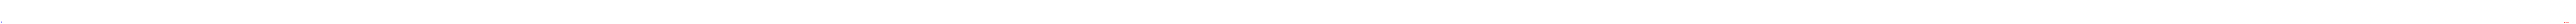

In [33]:
wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]!=im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(120, 0, val[3], fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(np.transpose(im,(2,1,0)))

In [34]:
right=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]==im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(right[:20]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(120, 0, round(val[3], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(np.transpose(im,(2,1,0)))

<Figure size 864x864 with 0 Axes>